# MCT4052 Workshop 8a: Tensorflow-Keras ANN Classifier

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

[Tensorflow](https://www.tensorflow.org/) is a library for machine learning developed by Google, which is particularly focused on deep neural networks. Compared to scikit-learn, Tensorflow present a lof of advantages, especially for the real-world ddevelopment and deployment of machine learning applications (supports variety of programming language including JavaScript for the browser, optimized and GPU-accelerated computation including support for IoT platforms, etc.) Over the years, Tenrosflow (from version 2) has also integrated [Keras](https://keras.io/), which is a sort of Python interface for Tensorflow (used to be distributed as a different package).

When using Tensorflow in Python (especially if we want to remain on the easy side) we will often use sub packages that belongs to keras sub module.

This and the following Tensorflow-Keras examples are adapted from the excellent collection of [Tensorflow Tutorials](https://www.tensorflow.org/tutorials). For more info refer to the [Tensorflow API](https://www.tensorflow.org/versions) and [Keras API](https://keras.io/api/). Mind that Tensorflow API changes fairly rapidly (compared to other packages/libraries). Therefore, it is good to keep track of which Tensorflow version was used for development.

Generally, the latest versions of Tensorflow are able to work with data organized as Numpy arrays or Python lists (other then Tensors). However, the library provides tools to convert a variety of data formats [to tensors](https://www.tensorflow.org/api_docs/python/tf/convert_to_tensor), and Tensors have the method [.numpy()](https://www.tensorflow.org/api_docs/python/tf/Tensor) to convert Tensors to Numpy arrays.

Tensorflow (as well as scikit-learn) models work with numerical inputs (inputs represent features or raw data). However, at times we might be working with textual annotation (e.g. songs metadata) which has to be converted to numbers (e.g. integers). Tensorflow provides plenty of utilities for this task (not hard to code that in Python by yourself) under the [feature_column](https://www.tensorflow.org/api_docs/python/tf/feature_column) module (for instance [this](https://www.tensorflow.org/api_docs/python/tf/feature_column/categorical_column_with_vocabulary_list) can be quite handy with metadata).

Finally, [Tensorboard](https://www.tensorflow.org/tensorboard) provides handy visualization and tooling needed for machine learning experimentation, while [HParams Dashboard](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams) can help with automating hyperparameters tuning (to a certain extent, it may be preferred to use [Optuna](https://optuna.org/) as we can bring in into the search as many elements we want, including those non linked-depending on Tensorflow models).

This notebook shows how to train, test and use an ANN for classification in tensorflow. We use the same dataset used in earlier Workshops. Besides performing the training/testing task, we also explore some of the additional options/parameters that Tensorflow allow us to specify/customize. Mind that often in Tensorflow documentation/tutorials authors build classess/methods on top of Tensorflo API, which is something we are not doing in this notebook.

### 1. Importing Tensorflow and Keras

It is important to check the version we are using (this was written with 2.7).

In [2]:
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use("seaborn-v0_8")
import IPython.display as Ipd
import os
import sklearn
import scipy
import datetime

%matplotlib inline
%config IPCompleter.greedy=True

# Import TensorFlow and Keras
import tensorflow as tf

# display tensorflow version (this notwbook was developed with 2.7)
print(tf.__version__)

2.10.0


### 2. Computing features and splitting the dataset

This time we store the features in an numpy array of matrices (i.e. a 3D array) ad tensorflow is able to "flatten" the data internally (is instructed to do so).

In [4]:
sr = 44100

def lin_interp_2d(data, out_size):
    
    x_in_size = data.shape[1]
    y_in_size = data.shape[0]
    x_in = np.arange(0,x_in_size)
    y_in = np.arange(0,y_in_size)
    interpolator = scipy.interpolate.interp2d(x_in, y_in, data, kind='linear')
    x_out = np.arange(0,x_in_size-1,((x_in_size-1)/out_size[1]))
    y_out = np.arange(0,y_in_size-1,((y_in_size-1)/out_size[0]))
    output = interpolator(x_out, y_out)
    output = output[0:out_size[0],0:out_size[1]]
    
    return output

def extract_features(filename, sr):
    
    signal, dummy = librosa.load(filename, sr=sr, mono=True)
    
    output = librosa.feature.mfcc(y=signal, n_mfcc=15)
    
    output = lin_interp_2d(output, (15,15)) # scaling to identical lenght
    
    return output

filenames = os.listdir('./data/examples2')
features = np.zeros((len(filenames),15,15)) #3D Numpy array to store MFCC computed e changed if using more or less features)
labels = np.zeros((len(filenames)))
classes = ['kick','snare','cymbal','clap']

for i in range(len(filenames)):
    features[i] = extract_features('./data/examples2/'+filenames[i], sr) # alternative features[i,:,:]
    if filenames[i].find('kick') != -1:
        labels[i] = 0
    elif filenames[i].find('snare') != -1:
        labels[i] = 1
    elif filenames[i].find('cymbal') != -1:
        labels[i] = 2
    elif filenames[i].find('clap') != -1:
        labels[i] = 3

print('Done!')

Done!


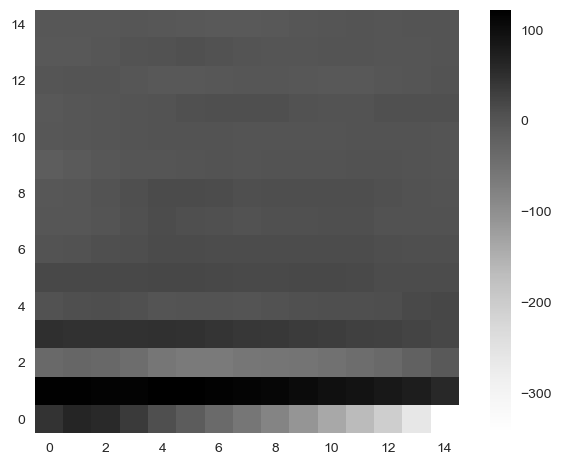

In [5]:
# displaying the MFCC for one example (change the integer to see a different example)
# This is a simple plotting using imshow (on the frequency axis low frequency are on top)

plt.figure()
plt.imshow(features[0], origin='lower') #change 
plt.colorbar()
plt.grid(False)
plt.show()

In [6]:
# for the splitting we still use scikit learn

from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, lab_train, lab_test = train_test_split(features, labels, test_size=0.2)

### 3. Defining, compiling, training and using the ANN

At first we define a [sequential model](https://keras.io/api/models/sequential/) which dimensionality has to match the input and expected output. The sequential model can stack any sequence of [layers](https://keras.io/api/layers/).

Then we compile the model specifying the [loss function](https://www.tensorflow.org/api_docs/python/tf/keras/losses) and [metric](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) to evaluate performances.

Then we fit the model, keeping track fo the history and specifying several parameters (refer to the documentation of the [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model) method.

Finally we display losses, assess performance on test set, and use the trained model to make a single prediction.

In [9]:
# building the model, the input layer must match the input data
# for classification we need an output for each class

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(15, 15)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 225)               0         
                                                                 
 dense_2 (Dense)             (None, 20)                4520      
                                                                 
 dense_3 (Dense)             (None, 4)                 84        
                                                                 
Total params: 4,604
Trainable params: 4,604
Non-trainable params: 0
_________________________________________________________________


In [10]:
# setting loss function and metric

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
# fitting the model and setting some parameters

history = model.fit(
    feat_train,
    lab_train,
    batch_size=8,
    epochs=10,
    validation_split = 0.1,
    shuffle=True
)

Epoch 1/10


2023-03-21 21:44:00.072850: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-21 21:44:00.285414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 2s 34ms/step - loss: 105.9068 - accuracy: 0.4286 - val_loss: 33.6104 - val_accuracy: 0.4286
Epoch 2/10
11/15 [=====================>........] - ETA: 0s - loss: 12.3792 - accuracy: 0.5455

2023-03-21 21:44:02.323153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 0s 7ms/step - loss: 10.8435 - accuracy: 0.5714 - val_loss: 5.9942 - val_accuracy: 0.6429
Epoch 3/10
15/15 [==============================] - 0s 6ms/step - loss: 3.7641 - accuracy: 0.7143 - val_loss: 2.9755 - val_accuracy: 0.7857
Epoch 4/10
15/15 [==============================] - 0s 7ms/step - loss: 2.3568 - accuracy: 0.8571 - val_loss: 2.6465 - val_accuracy: 0.7857
Epoch 5/10
15/15 [==============================] - 0s 7ms/step - loss: 1.3392 - accuracy: 0.8739 - val_loss: 2.5998 - val_accuracy: 0.7857
Epoch 6/10
15/15 [==============================] - 0s 7ms/step - loss: 0.9284 - accuracy: 0.9244 - val_loss: 2.5909 - val_accuracy: 0.7857
Epoch 7/10
15/15 [==============================] - 0s 7ms/step - loss: 0.7618 - accuracy: 0.9328 - val_loss: 3.1220 - val_accuracy: 0.7143
Epoch 8/10
15/15 [==============================] - 0s 7ms/step - loss: 0.5286 - accuracy: 0.9328 - val_loss: 3.6070 - val_accuracy: 0.8571
Epoch 9/10
15/15 [============

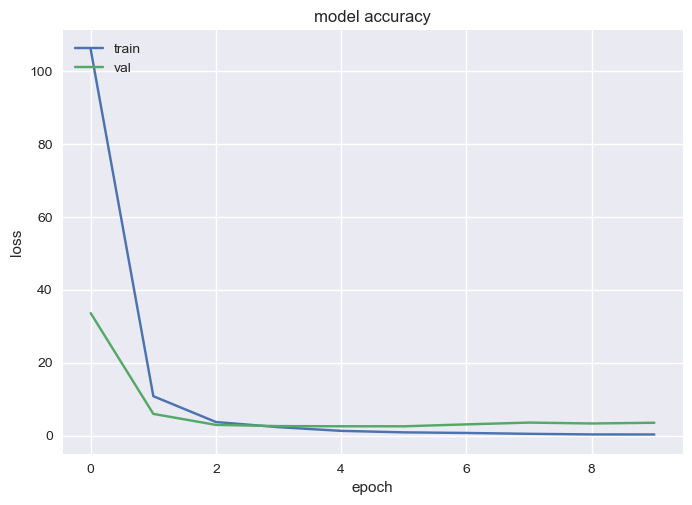

In [12]:
# plotting validation and train loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
# evaluating performance on test set

test_loss, test_acc = model.evaluate(feat_test,  lab_test, verbose=2)

print('\nTest accuracy:', test_acc)

2/2 - 0s - loss: 2.1611 - accuracy: 0.8235 - 250ms/epoch - 125ms/step

Test accuracy: 0.8235294222831726


In [14]:
# predictions on the entire test set

predictions = model.predict(feat_test)
print(predictions)

2/2 [==============================] - 0s 6ms/step
[[-4.02484512e+01  3.74935989e+01  1.10025986e+02  1.06769012e+02]
 [ 2.87502432e+00  3.29016685e+00  2.55091858e+01  4.05869942e+01]
 [ 2.71309452e+01  8.05459023e+00  8.77456093e+00  1.65923729e+01]
 [-3.90879898e+01 -2.30639839e+00  1.23899429e+02  1.02807648e+02]
 [-2.60017681e+01  9.91499252e+01  6.69735794e+01  8.60823669e+01]
 [-3.06774578e+01  1.50967979e+00  1.12607536e+02  7.54231033e+01]
 [-9.82732868e+00  2.99949512e+01  1.58994617e+01  2.20201740e+01]
 [-2.54599590e+01  5.97946739e+00  9.59209824e+01  7.14474258e+01]
 [ 1.77715838e+00  2.50625343e+01  7.02048779e+00  2.93041458e+01]
 [-5.56167459e+00 -4.85364189e+01  3.14165535e+01 -1.08358532e-01]
 [ 8.02457452e-01  2.53656120e+01  1.19457893e+01  3.28497581e+01]
 [-5.61048813e+01  1.14496849e+02  2.99864368e+01  7.64531250e+01]
 [-2.64519787e+01  1.52613506e+01  8.66107712e+01  7.70022964e+01]
 [ 2.48187885e+01 -5.26883278e+01  8.68304634e+00 -1.49793065e+00]
 [ 4.837485

2023-03-21 21:44:11.572731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [15]:
# predictions on a single example (first we have to convert it to (0, 15, 15)  entire test set

example = feat_test[0,:,:]

example = (np.expand_dims(example,0))

prediction = model.predict(example)

print(prediction)
print(np.argmax(prediction))

1/1 [==============================] - 0s 127ms/step
[[-40.248383  37.49353  110.02591  106.76895 ]]
2


In [16]:
# adding a softmax layer for probabilistic output
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

example = feat_test[0,:,:]

example = (np.expand_dims(example,0))

prediction = probability_model.predict(example)

print(prediction)
print(np.argmax(prediction))

1/1 [==============================] - 0s 35ms/step
[[0.0000000e+00 3.0421374e-32 9.6292239e-01 3.7077662e-02]]
2


2023-03-21 21:44:14.015002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### 4. Follow up activities

1. Use the [ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) to automatically save models throughout the training process.

2. Use the [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to terminate the training based onn a condition rather than completing a given number of epochs.

3. Display Tensorboard visualizations by adding the code in the cell below

4. Try to change the network architecture by:
 * Accepting an input that has been already "flattened" (requires to change also feature generation)
 * Integrate the softax layer from the very beginning (rather than a post addition)
 * Add extra hidden layers
 * Add a [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer to avoid overfitting (can be handy when working on 5).
 * Add a [Normalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization) layer at the beginning of the network (can be handy since the scikit learn scaler does not work with 3D Numpy arrays)
 
5. Following this [tutorial](https://www.tensorflow.org/tutorials/audio/simple_audio), try to run the classification working directly on rad audio (load only the first 200ms of audio, all files should be at least 200ms long). In particular, use the method [tf.audio.decode_wav](https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav) to load raw audio into a tensor (you can still use librosa if you prefer).

6. Experiment with your own data.


In [17]:
# load tensorboard (do this early in the notebook)
%load_ext tensorboard

# these must be somewhere before the fit method (also, is a good practice to clear the folder before running, using "!rm -rf ./logs/")
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks=[tensorboard_callback] # this is a parameter for the fit method

# after the model had been trained run this
%tensorboard --logdir logs/fit